In [2]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Coded_Segments.csv")
print(df.head())

               Dokumentname         Code  Anfang  Ende  \
0  reflection_assignment_P1      Level 1       1     1   
1  reflection_assignment_P1      Level 1       1     1   
2  reflection_assignment_P1      Level 1       1     1   
3  reflection_assignment_P1  Level 2 (a)       1     1   
4  reflection_assignment_P1  Level 2 (a)       1     1   

                                             Segment  
0  I am a newbie in data science (DS). On the one...  
1  However, the handling of data in basic cogniti...  
2  The HCDS course was largely aimed at a critica...  
3  Among these topics, some messages particularly...  
4  First of all, I became aware of the importance...  


In [4]:
df['Code'].value_counts()

Code
Level 3        90
Level 1        69
Level 2 (b)    41
Level 2 (a)    31
Level 4         6
Name: count, dtype: int64

(array([69.,  0., 31.,  0.,  0., 41.,  0., 90.,  0.,  6.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

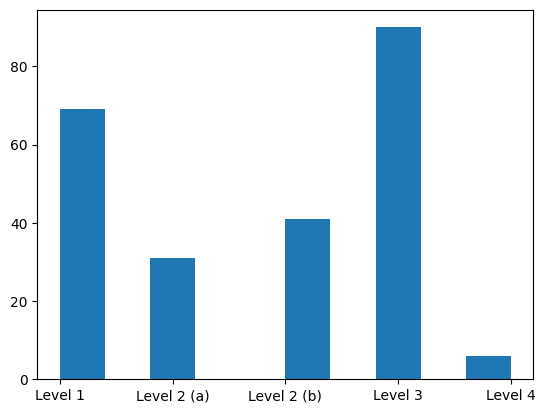

In [5]:
plt.hist(sorted(df['Code']))

In [6]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['Code'])

    # handle imbalanced dataset
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(df[['Segment']], df['class'])
    df_resampled = pd.DataFrame({'Segment': X_resampled['Segment'], 'class': y_resampled})

    print(f"Original dataset shape: {df.shape}")
    print(f"Resampled dataset shape: {df_resampled.shape}")

    return df_resampled, le

In [7]:
df_resampled, label_encoder = preprocess_data(df)
print(df_resampled)

Original dataset shape: (237, 6)
Resampled dataset shape: (450, 2)
                                               Segment  class
0    I am a newbie in data science (DS). On the one...      0
1    However, the handling of data in basic cogniti...      0
2    The HCDS course was largely aimed at a critica...      0
3    Among these topics, some messages particularly...      1
4    First of all, I became aware of the importance...      1
..                                                 ...    ...
445  The first concern, to begin  with, is to check...      4
446  The first concern, to begin  with, is to check...      4
447  Social nuances have shown how important it is ...      4
448  It also made me realise the high personal resp...      4
449  As an when my experience grew, I started to un...      4

[450 rows x 2 columns]


In [8]:
df_resampled['class'].value_counts()

class
0    90
1    90
4    90
2    90
3    90
Name: count, dtype: int64

(array([90.,  0., 90.,  0.,  0., 90.,  0., 90.,  0., 90.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

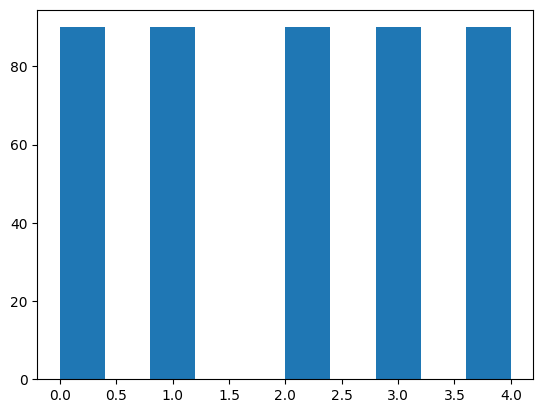

In [9]:
plt.hist(sorted(df_resampled['class']))

Validation Set Results:
Accuracy: 0.84
Cohen's Kappa: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.76        13
           1       1.00      0.93      0.96        14
           2       0.63      0.92      0.75        13
           3       0.69      0.69      0.69        13
           4       1.00      1.00      1.00        14

    accuracy                           0.84        67
   macro avg       0.86      0.83      0.83        67
weighted avg       0.87      0.84      0.84        67



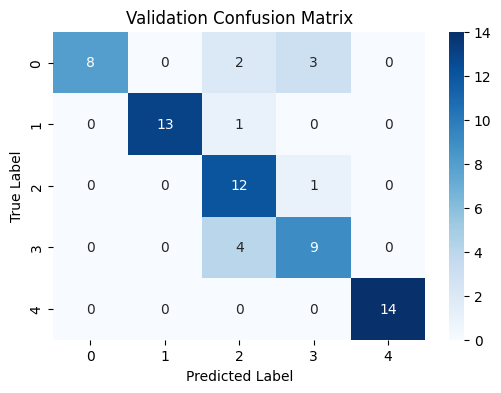


Test Set Results:
Accuracy: 0.87
Cohen's Kappa: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       1.00      0.77      0.87        13
           2       0.81      0.93      0.87        14
           3       0.75      0.86      0.80        14
           4       0.87      1.00      0.93        13

    accuracy                           0.87        68
   macro avg       0.89      0.87      0.87        68
weighted avg       0.88      0.87      0.87        68



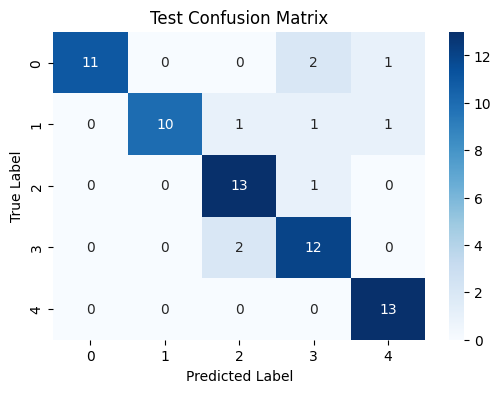

In [10]:
# Preprocessing
# Split into training, validation and test sets
train_df, temp_df = train_test_split(df_resampled, test_size=0.3, stratify=df_resampled['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

# Extract text and labels
X_train, y_train = train_df['Segment'], train_df['class']
X_val, y_val = val_df['Segment'], val_df['class']
X_test, y_test = test_df['Segment'], test_df['class']

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Train the Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Evaluate on validation and test sets
nb_y_val_pred = nb_model.predict(X_val_tfidf)
nb_y_test_pred = nb_model.predict(X_test_tfidf)

# Metrics for validation set
nb_val_accuracy = accuracy_score(y_val, nb_y_val_pred)
nb_val_class_report = classification_report(y_val, nb_y_val_pred, zero_division=0)
nb_val_cohen_kappa = cohen_kappa_score(y_val, nb_y_val_pred)
nb_val_cm = confusion_matrix(y_val, nb_y_val_pred)

# Metrics for test set
nb_test_accuracy = accuracy_score(y_test, nb_y_test_pred)
nb_test_class_report = classification_report(y_test, nb_y_test_pred, zero_division=0)
nb_test_cohen_kappa = cohen_kappa_score(y_test, nb_y_test_pred)
nb_test_cm = confusion_matrix(y_test, nb_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {nb_val_accuracy:.2f}")
print(f"Cohen's Kappa: {nb_val_cohen_kappa:.2f}")
print("Classification Report:")
print(nb_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(nb_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print("\nTest Set Results:")
print(f"Accuracy: {nb_test_accuracy:.2f}")
print(f"Cohen's Kappa: {nb_test_cohen_kappa:.2f}")
print("Classification Report:")
print(nb_test_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(nb_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

In [11]:
# Get the feature names (words) from the TF-IDF vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Get the log probabilities for each feature (word) for each class
class_feature_log_prob = nb_model.feature_log_prob_

# For each class, find the most important words
for class_idx, class_log_probs in enumerate(class_feature_log_prob):
    print(f"\nTop words for class {class_idx}:")

    # Get the indices of the top 10 least associated words (sorted by importance)
    top10_idx = class_log_probs.argsort()[-10:]

    # Display the words and their importance
    for idx in top10_idx:
        print(f"{feature_names[idx]}: {class_log_probs[idx]:.4f}")


Top words for class 0:
science: -6.7162
we: -6.7051
model: -6.7015
is: -6.6601
in: -6.6061
of: -6.4058
and: -6.2914
data: -6.2660
to: -6.2477
the: -5.6639

Top words for class 1:
course: -6.7696
be: -6.7129
assignments: -6.7081
human: -6.6646
science: -6.5073
to: -6.4257
of: -6.3650
data: -6.3580
and: -6.2519
the: -5.7604

Top words for class 2:
in: -6.6081
this: -6.5479
data: -6.5308
course: -6.5278
as: -6.5197
was: -6.4105
and: -6.3697
of: -6.2057
to: -6.1969
the: -5.5438

Top words for class 3:
would: -6.7487
as: -6.7302
is: -6.6996
be: -6.6507
data: -6.5774
in: -6.5738
of: -6.3571
and: -6.2091
to: -6.1096
the: -5.6772

Top words for class 4:
be: -6.4015
in: -6.3999
have: -6.3751
social: -6.3231
and: -6.2411
that: -6.1959
is: -5.9624
of: -5.9026
to: -5.7805
the: -5.5036


In [12]:
# Average log probabilities across all classes
global_feature_importance = np.mean(class_feature_log_prob, axis=0)

# Get the bottom 20 words
top20_global_idx = global_feature_importance.argsort()[-20:]

print("Top 20 least associated words overall:")
for idx in top20_global_idx:
    print(f"{feature_names[idx]}: {global_feature_importance[idx]:.4f}")

Top 20 least associated words overall:
with: -7.0205
have: -7.0165
science: -6.9857
course: -6.9424
are: -6.9141
was: -6.9017
as: -6.8872
for: -6.8834
on: -6.8682
this: -6.8349
it: -6.8111
that: -6.7359
be: -6.7168
in: -6.6015
is: -6.5936
data: -6.4725
and: -6.2726
of: -6.2472
to: -6.1521
the: -5.6298
